# Cleaning the groundtruth images from their spurious pixels

In [8]:
import os
import h5py
from matplotlib import pyplot as plt

In [179]:
import numpy as np
from numpy import newaxis
from skimage import morphology as mo
from scipy.ndimage import distance_transform_bf as distance

In [132]:
def distanceTransform(bIm):
    #from pythonvision.org
    dist = distance(bIm)
    dist = dist.max() - dist
    dist -= dist.min()
    dist = dist/float(dist.ptp()) * 255
    dist = dist.astype(np.uint8)
    return dist

def clean_ground_truth(gd_lab, size = 2):
    """Remove spurious pixels from badly labelled groundtruth image
    returns three binary images (One hot shot) first and a labelled image.
    """
    mask = gd_lab > 0
    dmap = distanceTransform(mask)
        
    cleaned_lab1 = mo.binary_opening(gd_lab == 1, selem = mo.disk(size))
    cleaned_lab2 = mo.binary_opening(gd_lab == 2, selem = mo.disk(size))
    cleaned_lab3 = mo.binary_opening(gd_lab == 3, selem = mo.disk(size))
    
    seeds = cleaned_lab1+2*cleaned_lab2+3*cleaned_lab3
    seg = mo.watershed(dmap, markers = seeds, mask = 1*mask)
    chrom_lab1 = seg == 1
    chrom_lab2 = seg == 2
    overlapp = seg == 3
    
    return chrom_lab1, chrom_lab2, overlapp, seg



### Download the dataset  from its repository at github
https://github.com/jeanpat/DeepFISH/tree/master/dataset

In [20]:
!wget https://github.com/jeanpat/DeepFISH/blob/master/dataset/LowRes_13434_overlapping_pairs.h5  

--2019-12-20 09:04:27--  https://github.com/jeanpat/DeepFISH/blob/master/dataset/LowRes_13434_overlapping_pairs.h5
Résolution de github.com (github.com)… 140.82.118.4
Connexion à github.com (github.com)|140.82.118.4|:443… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : non indiqué [text/html]
Enregistre : «LowRes_13434_overlapping_pairs.h5»

LowRes_13434_overla     [ <=>                ]  62,54K  --.-KB/s    ds 0,1s    

2019-12-20 09:04:28 (630 KB/s) - «LowRes_13434_overlapping_pairs.h5» enregistré [64037]



In [44]:
filename = './LowRes_13434_overlapping_pairs.h5'
h5f = h5py.File(filename,'r')
pairs = h5f['dataset_1'][:]
h5f.close()
print('dataset is a numpy array of shape:', pairs.shape)

dataset is a numpy array of shape: (13434, 94, 93, 2)


In [146]:
N = 11508
grey = pairs[N,:,:,0]
g_truth = pairs[N,:,:,1]
l1, l2, l3, seg = clean_ground_truth(g_truth, size = 1)

In [175]:
test = np.dstack((grey, g_truth))
print(test.shape)
t2 = np.stack((test,test))
print(t2.shape)

(94, 93, 2)
(2, 94, 93, 2)


### Let's compare the groundtruth image befor and after cleaning

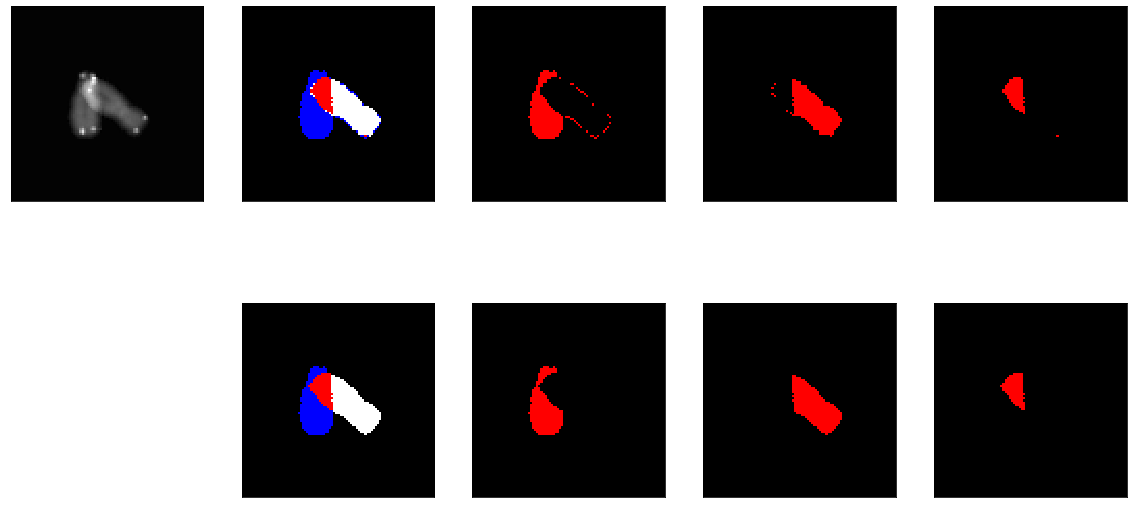

In [165]:
plt.figure(figsize=(20,10))

plt.subplot(251,xticks=[],yticks=[])
plt.imshow(grey, cmap=plt.cm.gray)
plt.subplot(252,xticks=[],yticks=[])
plt.imshow(g_truth, cmap=plt.cm.flag_r)
plt.subplot(253,xticks=[],yticks=[])
plt.imshow(g_truth == 1, cmap=plt.cm.flag_r)
plt.subplot(254,xticks=[],yticks=[])
plt.imshow(g_truth == 2, cmap=plt.cm.flag_r)
plt.subplot(255,xticks=[],yticks=[])
plt.imshow(g_truth == 3, cmap=plt.cm.flag_r)

#plt.subplot(256,xticks=[],yticks=[])
#plt.imshow(mo.white_tophat(grey, selem = mo.disk(2)) > 0, cmap=plt.cm.jet)
plt.subplot(257,xticks=[],yticks=[])
plt.imshow(l1+2*l2+3*l3, cmap=plt.cm.flag_r)
plt.subplot(258,xticks=[],yticks=[])
plt.imshow(l1, cmap=plt.cm.flag_r)
plt.subplot(259,xticks=[],yticks=[])
plt.imshow(l2, cmap=plt.cm.flag_r)
plt.subplot(2,5,10,xticks=[],yticks=[])
plt.imshow(l3, cmap=plt.cm.flag_r)

# Clean the whole dataset

In [196]:
new_data = np.zeros((1,94,93,2), dtype = int)
N = pairs.shape[0]#10
for idx in range(N):
    g_truth = pairs[idx,:,:,1]
    grey = pairs[idx,:,:,0]
    _, _, _, seg = clean_ground_truth(g_truth, size = 1)
    paired = np.dstack((grey, seg))
    #
    #https://stackoverflow.com/questions/7372316/how-to-make-a-2d-numpy-array-a-3d-array/7372678
    #
    new_data = np.concatenate((new_data, paired[newaxis,:, :, :]))
new_data = new_data[1:,:,:,:]

In [1]:
plt.figure(figsize=(20,10))
N=10580
grey = new_data[N,:,:,0]
g_truth = new_data[N,:,:,1]

plt.subplot(121,xticks=[],yticks=[])
plt.imshow(grey, cmap=plt.cm.gray)
plt.subplot(122,xticks=[],yticks=[])
plt.imshow(g_truth, cmap=plt.cm.flag_r)


NameError: name 'plt' is not defined

### Save the dataset using hdf5 format

In [200]:
filename = './Cleaned_LowRes_13434_overlapping_pairs.h5'
hf = h5py.File(filename,'w')
hf.create_dataset('13434_overlapping_chrom_pairs_LowRes', data=new_data, compression='gzip', compression_opts=9)
hf.close()